# Two Stage Hierarchical Classifier for AD
This approach will:
1. First classify images as "Dementia" vs "Non-Dementia" (binary classification)
2. Then classify "Dementia" images into severity levels (multi-class classification)
    * Will implement later if binary works well



## Data preparation and pre processing

In [4]:
def prepare_balanced_data():
    """
    Prepares data with balanced subjects across classes
    Returns: image_paths, binary_labels, detailed_labels, subjects
    """
    # Dataset path
    dataset_path = './OASIS Data'
    
    # Initialize lists
    image_paths = []
    binary_labels = []  # 0 for Non-Demented, 1 for any type of Dementia
    detailed_labels = []  # 0: Non-Demented, 1: Mild, 2: Moderate, 3: Very Mild
    subjects = []
    
    # Dictionary to track subjects and their classes
    subject_images = {}  # {subject_id: [(image_path, binary_label, detailed_label), ...]}
    
    print(f"Accessing dataset from: {dataset_path}")
    
    # Process Non-Demented images
    non_demented_path = os.path.join(dataset_path, 'Non Demented')
    print(f"Loading Non-Demented images from: {non_demented_path}")
    non_demented_files = os.listdir(non_demented_path)
    print(f"Found {len(non_demented_files)} Non-Demented files")
    
    # Process all non-demented files
    for image_filename in non_demented_files:
        if not os.path.isfile(os.path.join(non_demented_path, image_filename)):
            continue
            
        # Extract subject ID
        try:
            subject_id = image_filename.split('OAS1_')[1].split('_')[0]
        except:
            print(f"Skipping file with invalid format: {image_filename}")
            continue
            
        image_path = os.path.join(non_demented_path, image_filename)
        
        # Add to subject dictionary
        if subject_id not in subject_images:
            subject_images[subject_id] = []
        subject_images[subject_id].append((image_path, 0, 0))  # (path, binary_label, detailed_label)
    
    # Process dementia classes
    dementia_classes = {
        'Mild Dementia': 1,
        'Moderate Dementia': 2,
        'Very mild Dementia': 3
    }
    
    for category, label in dementia_classes.items():
        category_path = os.path.join(dataset_path, category)
        print(f"Loading {category} images from: {category_path}")
        category_files = os.listdir(category_path)
        print(f"Found {len(category_files)} {category} files")
        
        for image_filename in category_files:
            if not os.path.isfile(os.path.join(category_path, image_filename)):
                continue
                
            # Extract subject ID
            try:
                subject_id = image_filename.split('OAS1_')[1].split('_')[0]
            except:
                print(f"Skipping file with invalid format: {image_filename}")
                continue
                
            image_path = os.path.join(category_path, image_filename)
            
            # Add to subject dictionary
            if subject_id not in subject_images:
                subject_images[subject_id] = []
            subject_images[subject_id].append((image_path, 1, label))  # (path, binary_label, detailed_label)
    
    # Analyze subject distribution
    subject_class = {}  # {subject_id: binary_class}
    for subject_id, images in subject_images.items():
        # Determine the majority class for this subject
        class_counts = Counter([img[1] for img in images])
        majority_class = class_counts.most_common(1)[0][0]
        subject_class[subject_id] = majority_class
    
    # Count subjects per class
    class0_subjects = [s for s, c in subject_class.items() if c == 0]
    class1_subjects = [s for s, c in subject_class.items() if c == 1]
    
    print(f"Found {len(class0_subjects)} subjects in class 0 (Non-Demented)")
    print(f"Found {len(class1_subjects)} subjects in class 1 (Dementia)")
    
    # Balance number of subjects per class if needed
    min_subjects = min(len(class0_subjects), len(class1_subjects))
    if len(class0_subjects) > min_subjects:
        class0_subjects = random.sample(class0_subjects, min_subjects)
    if len(class1_subjects) > min_subjects:
        class1_subjects = random.sample(class1_subjects, min_subjects)
    
    print(f"Using {len(class0_subjects)} subjects from each class for balance")
    
    # Collect all images from selected subjects
    selected_subjects = class0_subjects + class1_subjects
    
    for subject_id in selected_subjects:
        for img_path, binary_label, detailed_label in subject_images[subject_id]:
            image_paths.append(img_path)
            binary_labels.append(binary_label)
            detailed_labels.append(detailed_label)
            subjects.append(subject_id)
    
    # Convert to numpy arrays
    binary_labels = np.array(binary_labels)
    detailed_labels = np.array(detailed_labels)
    
    # Print statistics
    print(f"Total images: {len(image_paths)}")
    print(f"Total subjects: {len(set(subjects))}")
    print(f"Binary label distribution: {np.bincount(binary_labels)}")
    
    # Print detailed statistics
    subject_counter = Counter(subjects)
    print(f"Number of unique subjects: {len(subject_counter)}")
    print(f"Average images per subject: {len(subjects) / len(subject_counter):.1f}")
    print(f"Top 10 subjects by image count: {sorted(subject_counter.items(), key=lambda x: x[1], reverse=True)[:10]}")
    
    return image_paths, binary_labels, detailed_labels, subjects

In [5]:
"""
Subject based train/validation split to prevent data leakage. This ensures that the demented class has a balanced distribution of subjects in the train and validation sets.

This script works by first getting the unique subjects found from prepare_binary_data().

Then, it creates a mapping of subjects to their binary classes.

Finally, it splits the data into train and validation sets.
"""

def split_by_subject(image_paths, binary_labels, detailed_labels, subjects):
    # Get unique subjects
    subject_counter = Counter(subjects)
    print(f"Number of unique subjects: {len(subject_counter)}")
    print(f"Average images per subject: {len(subjects) / len(subject_counter):.1f}")
    print(f"Subject distribution: {sorted(subject_counter.items(), key=lambda x: x[1], reverse=True)[:10]}")
    
    # Create a mapping of subjects to their classes (for stratified split)
    subject_to_binary_class = {}
    for i, subject in enumerate(subjects):
        if subject not in subject_to_binary_class:
            subject_to_binary_class[subject] = binary_labels[i]

    print(f'Subject to binary class: {subject_to_binary_class}')
    
    # Get subjects for each binary class
    class0_subjects = [s for s, c in subject_to_binary_class.items() if c == 0]
    class1_subjects = [s for s, c in subject_to_binary_class.items() if c == 1]
    print(f'Class 0 subjects: {class0_subjects}')
    print(f'Class 1 subjects: {class1_subjects}')

    # Split each class separately to maintain class distribution
    train_class0, val_class0 = train_test_split(class0_subjects, test_size=0.2, random_state=42)
    train_class1, val_class1 = train_test_split(class1_subjects, test_size=0.2, random_state=42)
    
    # Combine
    train_subjects = train_class0 + train_class1
    val_subjects = val_class0 + val_class1
    
    # Get indices for train and validation
    train_indices = [i for i, subject in enumerate(subjects) if subject in train_subjects]
    val_indices = [i for i, subject in enumerate(subjects) if subject in val_subjects]
    
    return train_indices, val_indices

In [6]:
# Load images
def load_images(paths, img_size=(224, 224)):
    images = []
    for path in paths:
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to load image: {path}")
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
        except Exception as e:
            print(f"Error processing image {path}: {str(e)}")
    return np.array(images)

## Display Example MRI Scans from Each Class

Accessing dataset from: ./OASIS Data
Loading Non-Demented images from: ./OASIS Data/Non Demented
Found 67222 Non-Demented files
Loading Mild Dementia images from: ./OASIS Data/Mild Dementia
Found 5002 Mild Dementia files
Loading Moderate Dementia images from: ./OASIS Data/Moderate Dementia
Found 488 Moderate Dementia files
Loading Very mild Dementia images from: ./OASIS Data/Very mild Dementia
Found 13725 Very mild Dementia files
Found 266 subjects in class 0 (Non-Demented)
Found 81 subjects in class 1 (Dementia)
Using 81 subjects from each class for balance
Total images: 39833
Total subjects: 162
Binary label distribution: [20618 19215]
Number of unique subjects: 162
Average images per subject: 245.9
Top 10 subjects by image count: [('0236', 488), ('0117', 488), ('0150', 488), ('0092', 488), ('0145', 488), ('0080', 488), ('0254', 366), ('0319', 244), ('0260', 244), ('0376', 244)]


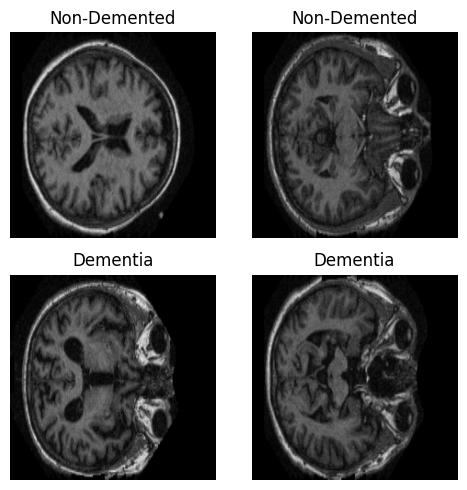

In [48]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Function to load images from the paths
def load_images(paths, img_size=(224, 224)):
    images = []
    for path in paths:
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to load image: {path}")
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
        except Exception as e:
            print(f"Error processing image {path}: {str(e)}")
    return np.array(images)

# Function to display images with labels
def display_random_images(image_paths, binary_labels, num_images=6):
    # Separate the image paths by class (0 = Non-Demented, 1 = Demented)
    non_demented_paths = [image_paths[i] for i in range(len(binary_labels)) if binary_labels[i] == 0]
    demented_paths = [image_paths[i] for i in range(len(binary_labels)) if binary_labels[i] == 1]
    
    # Randomly sample 3 images from each class
    selected_non_demented = random.sample(non_demented_paths, 2)
    selected_demented = random.sample(demented_paths, 2)
    
    # Combine the two lists of selected images
    selected_paths = selected_non_demented + selected_demented
    selected_labels = [0] * 2 + [1] * 2  # 3 Non-Demented (0) and 3 Demented (1)
    
    # Load the selected images
    images = load_images(selected_paths)
    
    # Set up the plot grid
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.ravel()
    
    # Display images
    for i in range(num_images):
        img = images[i]
        label = selected_labels[i]
        label_text = 'Dementia' if label == 1 else 'Non-Demented'
        
        # Convert image to RGB for displaying in matplotlib (if grayscale)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # Show the image
        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(label_text)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have the image paths and binary labels from prepare_balanced_data function
image_paths, binary_labels, detailed_labels, subjects = prepare_balanced_data()

# Display 6 random images: 3 demented and 3 non-demented
display_random_images(image_paths, binary_labels, num_images=4)

## Custom CNN Model

In [6]:
def train_with_group_kfold(n_splits=5, epochs=20):
    """
    Train the model using GroupKFold cross-validation
    to properly handle subject-based splitting
    """
    # Prepare data
    image_paths, binary_labels, detailed_labels, subjects = prepare_balanced_data()
    
    # Create a mapping of subjects to their classes
    subject_class = {}
    for i, subject in enumerate(subjects):
        subject_class[subject] = binary_labels[i]
    
    # Load images
    print("Loading images...")
    X = load_images(image_paths)
    y = binary_labels
    groups = np.array(subjects)
    
    # Setup GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    
    # Store results
    fold_results = []
    
    # Train on each fold
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"\n===== Training fold {fold+1}/{n_splits} =====")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Print fold statistics
        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        
        # Count unique subjects in each split
        train_subjects = set([groups[i] for i in train_idx])
        val_subjects = set([groups[i] for i in val_idx])
        # Improved version:
        # Create a dictionary mapping subject IDs to their classes for better visibility
        train_subject_classes = {subject: subject_class.get(subject, 'Unknown') for subject in train_subjects}
        val_subject_classes = {subject: subject_class.get(subject, 'Unknown') for subject in val_subjects}

        # Print detailed information
        print(f"Training subjects: {len(train_subjects)}")
        for subject, cls in train_subject_classes.items():
            class_name = "Non-Demented" if cls == 0 else "Dementia" if cls == 1 else "Unknown"
            print(f"  - Subject {subject}: Class {cls} ({class_name})")
            
        print(f"\nValidation subjects: {len(val_subjects)}")
        for subject, cls in val_subject_classes.items():
            class_name = "Non-Demented" if cls == 0 else "Dementia" if cls == 1 else "Unknown"
            print(f"  - Subject {subject}: Class {cls} ({class_name})")
        
        # Verify no subject overlap
        assert len(train_subjects.intersection(val_subjects)) == 0, "Subject leakage detected!"
        
        # Reshape to include channel dimension
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        
        # Create data generators with augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,  # Normalize pixel values
            rotation_range=15,  # Rotate images
            width_shift_range=0.1,  # Shift horizontally
            height_shift_range=0.1,  # Shift vertically
            shear_range=0.1,  # Shear
            zoom_range=0.1,  # Zoom
            horizontal_flip=True,  # Flip horizontally
            fill_mode='nearest'  # Fill strategy
        )
        
        val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize validation data
        
        # Create generators
        train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
        val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
        
        # Build model with regularization to prevent overfitting
        model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), 
                   kernel_regularizer=l2(0.001), padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            # Flatten and dense layers
            Flatten(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),  # Strong dropout to prevent overfitting
            Dense(1, activation='sigmoid')
        ])
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.0001),  # Low learning rate
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Print model summary
        model.summary()
        
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=10,  # Wait for 10 epochs before stopping
            restore_best_weights=True,  # Restore weights from best epoch
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # Reduce LR by 80% when plateauing
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
        
        # Train model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Evaluate model
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)
        fold_results.append(val_acc)
        
        print(f"Fold {fold+1} validation accuracy: {val_acc:.4f}")
        
        # Save model for this fold
        model.save(f'alzheimer_model_fold_{fold+1}.h5')
    
    # Print overall results
    print("\n===== Cross-validation Results =====")
    for i, acc in enumerate(fold_results):
        print(f"Fold {i+1}: {acc:.4f}")
    print(f"Average validation accuracy: {np.mean(fold_results):.4f}")
    print(f"Standard deviation: {np.std(fold_results):.4f}")
    
    return fold_results

In [ ]:
import os
import random
import numpy as np
import cv2
from collections import Counter
from sklearn.model_selection import GroupKFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

if __name__ == "__main__":
    train_with_group_kfold(n_splits=5, epochs=20)
    

## Create Confusion Matrices

Preparing test data...
Accessing dataset from: ./OASIS Data
Loading Non-Demented images from: ./OASIS Data/Non Demented
Found 67222 Non-Demented files
Loading Mild Dementia images from: ./OASIS Data/Mild Dementia
Found 5002 Mild Dementia files
Loading Moderate Dementia images from: ./OASIS Data/Moderate Dementia
Found 488 Moderate Dementia files
Loading Very mild Dementia images from: ./OASIS Data/Very mild Dementia
Found 13725 Very mild Dementia files
Found 266 subjects in class 0 (Non-Demented)
Found 81 subjects in class 1 (Dementia)
Using 81 subjects from each class for balance
Total images: 40199
Total subjects: 162
Binary label distribution: [20984 19215]
Number of unique subjects: 162
Average images per subject: 248.1
Top 10 subjects by image count: [('0111', 488), ('0092', 488), ('0191', 488), ('0061', 488), ('0202', 488), ('0249', 488), ('0117', 488), ('0150', 488), ('0279', 244), ('0049', 244)]
Loading test images...

===== Evaluating CNN model across 5 folds =====
Fold 1/5


Loaded model from alzheimer_model_fold_1.h5


Fold 2/5
Loaded model from alzheimer_model_fold_2.h5


Fold 3/5
Loaded model from alzheimer_model_fold_3.h5


Fold 4/5
Loaded model from alzheimer_model_fold_4.h5


Fold 5/5
Loaded model from alzheimer_model_fold_5.h5


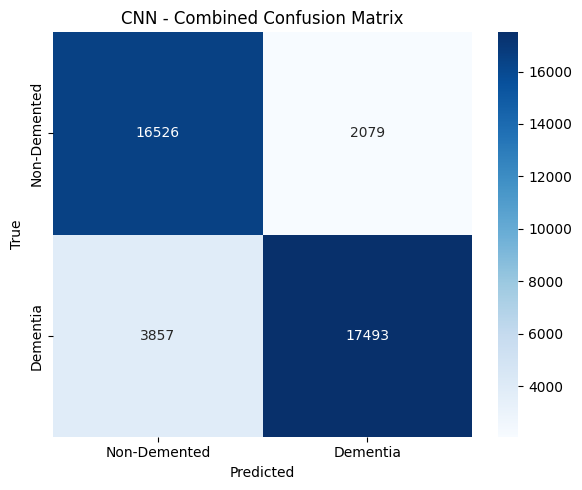


===== Evaluating TransferLearning model across 3 folds =====
Fold 1/3


Loaded model from mobilenetv2_alzheimer_model_fold_1.h5
Converted grayscale images to RGB for MobileNetV2
Fold 2/3


Loaded model from mobilenetv2_alzheimer_model_fold_2.h5
Fold 3/3


Loaded model from mobilenetv2_alzheimer_model_fold_3.h5


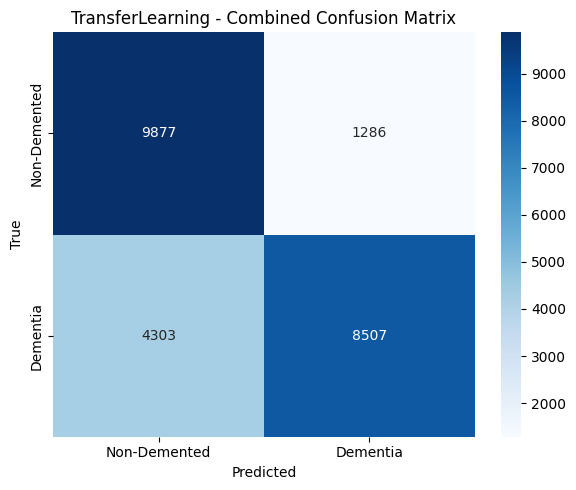

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

def evaluate_alzheimer_models(model_patterns, n_splits_dict, test_data=None):
    """
    Evaluate Alzheimer's models and return one combined confusion matrix per model.

    Parameters:
    -----------
    model_patterns : dict
        Model name to file path pattern (e.g., 'model_fold_{}.h5')
    n_splits_dict : dict
        Model name to number of folds
    test_data : tuple, optional (X_test, y_test, subjects_test)
        If None, test data is prepared using prepare_balanced_data()

    Returns:
    --------
    confusion_matrices : dict
        Model name to single confusion matrix aggregated over all folds
    """

    # Prepare test data if not provided
    if test_data is None:
        print("Preparing test data...")
        image_paths, binary_labels, detailed_labels, subjects = prepare_balanced_data()
        groups = np.array(subjects)
        gkf = GroupKFold(n_splits=5)

        for train_idx, test_idx in gkf.split(image_paths, binary_labels, groups):
            pass  # use last split

        test_paths = [image_paths[i] for i in test_idx]
        test_labels = [binary_labels[i] for i in test_idx]
        test_subjects = [subjects[i] for i in test_idx]

        print("Loading test images...")
        X_test = load_images(test_paths)
        y_test = np.array(test_labels)
        subjects_test = np.array(test_subjects)
    else:
        X_test, y_test, subjects_test = test_data

    if len(X_test.shape) == 3:
        X_test = X_test[..., np.newaxis]

    X_test = X_test / 255.0

    confusion_matrices = {}

    for model_label, model_path_pattern in model_patterns.items():
        n_splits = n_splits_dict[model_label]
        print(f"\n===== Evaluating {model_label} model across {n_splits} folds =====")

        all_preds = []
        all_true = []

        for fold in range(n_splits):
            print(f"Fold {fold + 1}/{n_splits}")
            model_path = model_path_pattern.format(fold + 1)

            try:
                model = load_model(model_path)
                print(f"Loaded model from {model_path}")
            except:
                print(f"Failed to load model from {model_path}. Skipping fold.")
                continue

            # Convert grayscale to RGB if needed
            if model_label == 'TransferLearning' and X_test.shape[-1] == 1:
                X_test = np.repeat(X_test, 3, axis=-1)
                print("Converted grayscale images to RGB for MobileNetV2")

            y_pred_prob = model.predict(X_test, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        # Compute combined confusion matrix
        cm = confusion_matrix(all_true, all_preds)
        confusion_matrices[model_label] = cm

        # 📊 Plot the combined confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Demented', 'Dementia'],
                    yticklabels=['Non-Demented', 'Dementia'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_label} - Combined Confusion Matrix')
        plt.tight_layout()
        plt.show()

    return confusion_matrices

model_patterns = {
    'CNN': 'alzheimer_model_fold_{}.h5',
    'TransferLearning': 'mobilenetv2_alzheimer_model_fold_{}.h5'
}

n_splits_dict = {
    'CNN': 5,
    'TransferLearning': 3
}

conf_matrices = evaluate_alzheimer_models(model_patterns, n_splits_dict)

## Transfer Learning Model with MobileNetV2


In [ ]:
import os
import random
import numpy as np
import cv2
from collections import Counter
from sklearn.model_selection import GroupKFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

if __name__ == "__main__":
    train_with_group_kfold_2(n_splits=3, epochs=20)
    

In [5]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import GroupKFold
import os
import random
import numpy as np
import cv2
from collections import Counter
from sklearn.model_selection import GroupKFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Main function to load data, preprocess, train, and evaluate the model
def train_with_group_kfold_2(n_splits=3, epochs=20):
    # Prepare data
    image_paths, binary_labels, detailed_labels, subjects = prepare_balanced_data()
    
    # Map subject to class
    subject_class = {subject: binary_labels[i] for i, subject in enumerate(subjects)}
    
    # Load images
    print("Loading images...")
    X = load_images(image_paths)  # Shape: (N, 224, 224)
    y = np.array(binary_labels)
    groups = np.array(subjects)

    # Convert grayscale to RGB (3 channels) - necessary for MobileNetV2
    X = np.repeat(X[..., np.newaxis], 3, axis=-1)  # Convert grayscale to 3-channel
    
    # Setup GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"\n===== Training fold {fold+1}/{n_splits} =====")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Print fold statistics
        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
        print(f"Training class distribution: {np.bincount(y_train)}")
        print(f"Validation class distribution: {np.bincount(y_val)}")
        
        # Count unique subjects in each split
        train_subjects = set([groups[i] for i in train_idx])
        val_subjects = set([groups[i] for i in val_idx])
        # Improved version:
        # Create a dictionary mapping subject IDs to their classes for better visibility
        train_subject_classes = {subject: subject_class.get(subject, 'Unknown') for subject in train_subjects}
        val_subject_classes = {subject: subject_class.get(subject, 'Unknown') for subject in val_subjects}

        # Print detailed information
        print(f"Training subjects: {len(train_subjects)}")
        for subject, cls in train_subject_classes.items():
            class_name = "Non-Demented" if cls == 0 else "Dementia" if cls == 1 else "Unknown"
            print(f"  - Subject {subject}: Class {cls} ({class_name})")
            
        print(f"\nValidation subjects: {len(val_subjects)}")
        for subject, cls in val_subject_classes.items():
            class_name = "Non-Demented" if cls == 0 else "Dementia" if cls == 1 else "Unknown"
            print(f"  - Subject {subject}: Class {cls} ({class_name})")
        
        # Verify no subject overlap
        assert len(train_subjects.intersection(val_subjects)) == 0, "Subject leakage detected!"
        
        # Image generators (data augmentation)
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        val_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow(X_train, y_train, batch_size=32)  # Batch size 16 for memory efficiency
        val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
        
        # Build MobileNetV2 model with custom layers
        input_shape = X_train.shape[1:]  # (224, 224, 3)
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        
        # Freeze the base model layers
        base_model.trainable = False
        
        # Add custom layers on top of MobileNetV2
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)  # Binary classification
        
        model = Model(inputs=base_model.input, outputs=output)
        
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        # Callbacks for early stopping and reducing learning rate
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )
        
        # Train the model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Evaluate the model on validation data
        val_loss, val_acc = model.evaluate(val_generator)
        fold_results.append(val_acc)
        print(f"Fold {fold+1} validation accuracy: {val_acc:.4f}")
        
        # Save the model for this fold
        model.save(f'mobilenetv2_alzheimer_model_fold_{fold+1}.h5')
    
    # Summary of cross-validation results
    print("\n===== Cross-validation Results =====")
    for i, acc in enumerate(fold_results):
        print(f"Fold {i+1}: {acc:.4f}")
    
    print(f"Average validation accuracy: {np.mean(fold_results):.4f}")
    print(f"Standard deviation: {np.std(fold_results):.4f}")
    
    return fold_results

# Run the training function with 3 splits for GroupKFold and 20 epochs
fold_results = train_with_group_kfold_2(n_splits=3, epochs=20)

Accessing dataset from: ./OASIS Data
Loading Non-Demented images from: ./OASIS Data/Non Demented
Found 67222 Non-Demented files
Loading Mild Dementia images from: ./OASIS Data/Mild Dementia
Found 5002 Mild Dementia files
Loading Moderate Dementia images from: ./OASIS Data/Moderate Dementia
Found 488 Moderate Dementia files
Loading Very mild Dementia images from: ./OASIS Data/Very mild Dementia
Found 13725 Very mild Dementia files
Found 266 subjects in class 0 (Non-Demented)
Found 81 subjects in class 1 (Dementia)
Using 81 subjects from each class for balance
Total images: 40260
Total subjects: 162
Binary label distribution: [21045 19215]
Number of unique subjects: 162
Average images per subject: 248.5
Top 10 subjects by image count: [('0156', 488), ('0368', 488), ('0117', 488), ('0249', 488), ('0101', 488), ('0236', 488), ('0191', 488), ('0254', 366), ('0004', 244), ('0381', 244)]
Loading images...

===== Training fold 1/3 =====
Training samples: 26901, Validation samples: 13359
Traini

/Users/samanthafranks/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 269s 318ms/step - accuracy: 0.5174 - loss: 0.8215 - val_accuracy: 0.6748 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 2/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 264s 314ms/step - accuracy: 0.6042 - loss: 0.6948 - val_accuracy: 0.7164 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 3/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 271s 323ms/step - accuracy: 0.6559 - loss: 0.6306 - val_accuracy: 0.7322 - val_loss: 0.5294 - learning_rate: 1.0000e-04
Epoch 4/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 270s 321ms/step - accuracy: 0.6820 - loss: 0.6020 - val_accuracy: 0.7397 - val_loss: 0.5174 - learning_rate: 1.0000e-04
Epoch 5/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 271s 322ms/step - accuracy: 0.6983 - loss: 0.5805 - val_accuracy: 0.7310 - val_loss: 0.5142 - learning_rate: 1.0000e-04
Epoch 6/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 265s 316ms/step - accuracy: 0.7069 - loss: 0.5709 - val_accuracy: 0.7303 - val_loss: 0.5114 - learning_rate: 1.0000e-04
Epoch 7/20
841/841 ━━━━━━━━━━━━━━━━━━━━ 

Fold 1 validation accuracy: 0.7509

===== Training fold 2/3 =====
Training samples: 26840, Validation samples: 13420
Training class distribution: [14762 12078]
Validation class distribution: [6283 7137]
Training subjects: 108
  - Subject 0043: Class 0 (Non-Demented)
  - Subject 0098: Class 1 (Dementia)
  - Subject 0023: Class 1 (Dementia)
  - Subject 0151: Class 0 (Non-Demented)
  - Subject 0205: Class 1 (Dementia)
  - Subject 0086: Class 0 (Non-Demented)
  - Subject 0016: Class 1 (Dementia)
  - Subject 0327: Class 0 (Non-Demented)
  - Subject 0011: Class 0 (Non-Demented)
  - Subject 0073: Class 1 (Dementia)
  - Subject 0378: Class 0 (Non-Demented)
  - Subject 0161: Class 1 (Dementia)
  - Subject 0283: Class 0 (Non-Demented)
  - Subject 0119: Class 0 (Non-Demented)
  - Subject 0342: Class 0 (Non-Demented)
  - Subject 0249: Class 0 (Non-Demented)
  - Subject 0278: Class 1 (Dementia)
  - Subject 0316: Class 1 (Dementia)
  - Subject 0078: Class 0 (Non-Demented)
  - Subject 0179: Class 1 (

Fold 2 validation accuracy: 0.7031

===== Training fold 3/3 =====
Training samples: 26779, Validation samples: 13481
Training class distribution: [13908 12871]
Validation class distribution: [7137 6344]
Training subjects: 107
  - Subject 0041: Class 1 (Dementia)
  - Subject 0098: Class 1 (Dementia)
  - Subject 0023: Class 1 (Dementia)
  - Subject 0185: Class 1 (Dementia)
  - Subject 0151: Class 0 (Non-Demented)
  - Subject 0273: Class 1 (Dementia)
  - Subject 0035: Class 1 (Dementia)
  - Subject 0086: Class 0 (Non-Demented)
  - Subject 0298: Class 1 (Dementia)
  - Subject 0016: Class 1 (Dementia)
  - Subject 0046: Class 1 (Dementia)
  - Subject 0352: Class 1 (Dementia)
  - Subject 0160: Class 0 (Non-Demented)
  - Subject 0011: Class 0 (Non-Demented)
  - Subject 0380: Class 1 (Dementia)
  - Subject 0176: Class 0 (Non-Demented)
  - Subject 0378: Class 0 (Non-Demented)
  - Subject 0120: Class 1 (Dementia)
  - Subject 0287: Class 1 (Dementia)
  - Subject 0317: Class 0 (Non-Demented)
  - Su

Fold 3 validation accuracy: 0.7017

===== Cross-validation Results =====
Fold 1: 0.7509
Fold 2: 0.7031
Fold 3: 0.7017
Average validation accuracy: 0.7186
Standard deviation: 0.0228
